# VOC Data Analysis

This notebook contains the analysis of three VOC datasets to showcase analytical capabilities.

## Load Libraries

In [396]:
from deep_translator import GoogleTranslator
import shap

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, auc, roc_curve, ConfusionMatrixDisplay


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob



import seaborn as sns
import warnings



warnings.filterwarnings('ignore')

## Breath Biopsy® OMNI® – Example Dataset

Data extracted from https://www.owlstonemedical.com/downloads/breath-biopsy-omni-dataset/

### Load data

In [397]:
omni_df = pd.read_csv(
    'Data/OMNI Example Data/Breath Biopsy OMNI example dataset.csv', encoding='unicode_escape')
omni_df.head()

,Sample,Tags,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,...,Feature 2649.1,Feature 2650.1,Feature 2651.1,Feature 2652.1,Feature 2653.1,Feature 2654.1,Feature 2655.1,Feature 2656.1,Feature 2657.1,Feature 2658.1
0,NaN,Name,Peak@1.631,Peak@1.636,Peak@1.640,Peak@1.640,"Cyclotetrasiloxane, octamethyl-",Peak@1.645,n-Hexane,Sulfur dioxide,...,Octacosane,Triphenylphosphine oxide,"4,4-Dimethyl-1-hexene",Heptacosane,"Pentane, 2,2-dimethyl-","1,4-Benzenedicarboxylic acid, bis(2-ethylhexyl...",Peak@41.300,Squalene,Tridecane,Heptacosane
1,NaN,RT [min],1.631,1.636,1.64,1.64,1.642,1.649,1.654,1.672,...,39.309,39.881,40.736,40.745,40.747,41.265,41.296,41.457,42.514,44.661
2,Breath v1,Area: 9684_14_742525_742533_14.raw (F2),NaN,166465,147540,NaN,842232,NaN,851317,1387296,...,0.103359719,0.103042666,0.046605493,0.10441031,0.04883203,0.0975084,0.066842853,0.00695915,0.25392772,0.325888775
3,Breath v4,Area: 9684_24_741931_742937_24.raw (F5),NaN,NaN,139324,NaN,571682,271335,843059,2560427,...,0.211885243,0.105913683,0.099332617,0.178123082,0.085369204,0.159792082,0.125330344,NaN,0.117369883,0.187566354
4,Breath v2,Area: 9684_30_762790_350749_30.raw (F7),NaN,183706,162169,NaN,965952,NaN,1208287,NaN,...,0.115181953,0.066891511,0.046309683,0.107611218,0.044432246,0.070320186,0.069750564,0.007421719,NaN,0.149357502


In [398]:
print("total number of breath samples is : {}".format(
      len(omni_df[omni_df['Sample'].str.contains('Breath', case=False, na=False)])))
print("total number of blank samples is : {}".format(
      len(omni_df[omni_df['Sample'].str.contains('Blank', case=False, na=False)])))

total number of breath samples is : 57
total number of blank samples is : 57


### Filter ‘on-breath’ compounds

In [399]:
# creathe breath and blanks df
omni_df_breath = omni_df[omni_df['Sample'].str.contains(
    'Breath', case=False, na=False)].drop(['Sample', 'Tags'], axis=1).apply(pd.to_numeric, errors='coerce')
omni_df_blanks = omni_df[omni_df['Sample'].str.contains(
    'Blank', case=False, na=False)].drop(['Sample', 'Tags'], axis=1).apply(pd.to_numeric, errors='coerce')
# remove Signals of 100,000 or less
omni_df_breath = omni_df_breath[omni_df_breath >= 100000]
# create metrics and filter based on mean+3*std of blanks
omni_df_blanks_st = omni_df_blanks.mean()+omni_df_blanks.std()*3
omni_df_breath_st = omni_df_breath.mean()
omni_df_comp = omni_df_breath_st[omni_df_breath_st >
                                 omni_df_blanks_st].reset_index()
omni_df_breath_filtered = omni_df_breath[omni_df_breath.columns[omni_df_breath.columns.isin(
    omni_df_comp['index'])]]
omni_df_breath_filtered.head()

,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 29,Feature 31,...,Feature 2545,Feature 2546,Feature 2555,Feature 2557,Feature 2561,Feature 2568,Feature 2571,Feature 2575,Feature 2578,Feature 2636
2,137590.0,306809.0,558638.0,3641748.0,NaN,574357.0,4479892.0,1120632.0,1456746,NaN,...,NaN,2411631.0,2738598.0,NaN,2493501.0,NaN,645578.0,1203159.0,1097956.0,40840176
3,NaN,1200806.0,3562409.0,4597294.0,237519.0,2155791.0,127871434.0,12601506.0,1839504,NaN,...,1126536.0,4500085.0,3851504.0,3926126.0,2074927.0,NaN,1116587.0,912961.0,1026879.0,42496919
4,NaN,2565235.0,7693637.0,3408666.0,555990.0,553501.0,269042480.0,27248753.0,587177,NaN,...,2106553.0,6833926.0,6815507.0,6822260.0,1674656.0,264986.0,1113486.0,814908.0,1309457.0,43950339
5,214649.0,452892.0,816866.0,8588400.0,214649.0,1009360.0,9132808.0,1374554.0,2343388,400661.0,...,856838.0,NaN,NaN,3678853.0,662229.0,145707.0,136279.0,276717.0,806171.0,18285202
6,NaN,694210.0,1319176.0,7641449.0,336946.0,1566102.0,13472934.0,2148697.0,1527543,NaN,...,NaN,3468242.0,NaN,3916702.0,1452196.0,185117.0,235513.0,423299.0,1021787.0,30109878


In [400]:
print("total number of features detected on breath that have more than 100000 \n \
      and an average of more than mean + 3 * std of blanks is : {}".format(
      len(omni_df_breath_filtered.columns)))

total number of features detected on breath that have more than 100000 
       and an average of more than mean + 3 * std of blanks is : 515


### Plots and insights

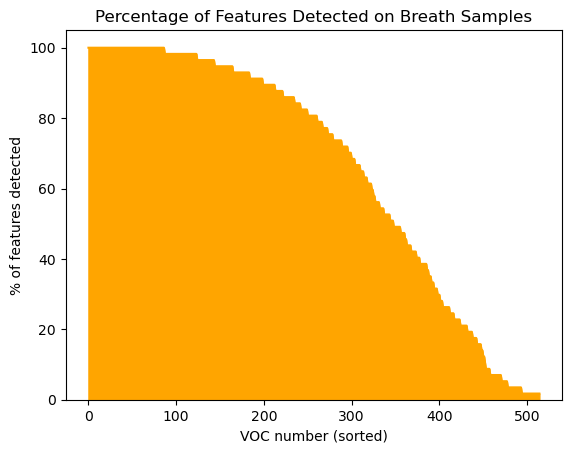

In [401]:
omni_df_ss_na = omni_df_breath_filtered.notna().sum().sort_values(ascending=False).reset_index(
    drop=True)*100/len(omni_df_breath_filtered)
omni_df_ss_na.plot(kind='area', color='orange')
plt.title('Percentage of Features Detected on Breath Samples')
plt.ylabel('% of features detected')
plt.xlabel('VOC number (sorted)')
plt.show()

Over 350 VOCs appear 50% of the time after filtering.

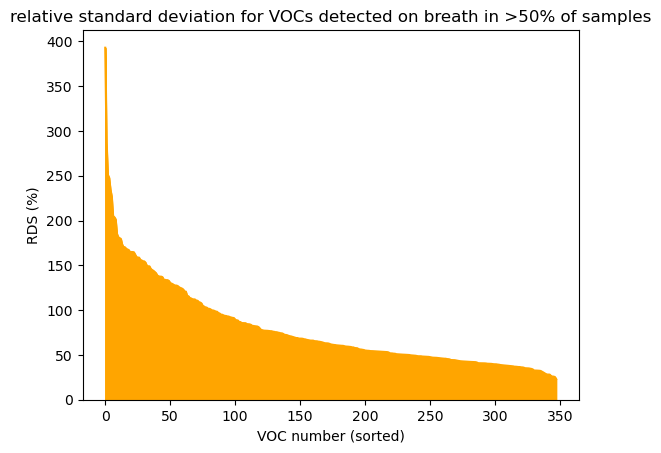

In [402]:
# calculate % of not na values per feature
omni_df_ss_na2 = omni_df_breath_filtered.notna().sum()*100 / \
    len(omni_df_breath_filtered)
# get features with more than 50%
omni_df_ss_na2 = omni_df_ss_na2[omni_df_ss_na2 >= 50].reset_index()
# drop features with less than 50%
omni_df_ss_rsd = omni_df_breath_filtered[omni_df_breath_filtered.columns[omni_df_breath_filtered.columns.isin(
    omni_df_ss_na2['index'])]]
# calculate relative standard deviation (RSD).
omni_df_ss_rsd_C = omni_df_ss_rsd.std(
    skipna=True)*100/omni_df_ss_rsd.mean(skipna=True)
# sort and plot
omni_df_ss_rsd_C = omni_df_ss_rsd_C.sort_values(
    ascending=False).reset_index(drop=True)
omni_df_ss_rsd_C.plot(kind='area', color='orange')
plt.title(
    'relative standard deviation for VOCs detected on breath in >50% of samples')
plt.ylabel('RDS (%)')
plt.xlabel('VOC number (sorted)')
plt.show()

In [403]:
print("The median inter-subject RSD across these VOCs was {}".format(omni_df_ss_rsd_C.median()))

The median inter-subject RSD across these VOCs was 61.841038512808936


## Pulmonary Disease Dataset

Data extracted from https://www.nature.com/articles/s41597-024-03052-2#Sec9

### Load data

In [404]:
# load csv files
asthma_df = pd.read_csv(

    'Data/pulmonary/Asthma_peaktable_ver3.csv').transpose().reset_index()

# formatting: remove first two rows and rename, and label ID

asthma_df.columns = asthma_df.iloc[1]

asthma_df.drop([0, 1], axis=0, inplace=True)

asthma_df.reset_index(inplace=True, drop=True)

asthma_df['IUPAC Name'] = asthma_df['IUPAC Name'].astype(
    int).astype(str)+str('-Asthma')
bronchi_df = pd.read_csv(

    'Data/pulmonary/Bronchi_peaktable_ver3.csv').transpose().reset_index()

# formatting: remove first two rows and rename, and label ID

bronchi_df.columns = bronchi_df.iloc[1]

bronchi_df.drop([0, 1], axis=0, inplace=True)

bronchi_df.reset_index(inplace=True, drop=True)

bronchi_df['IUPAC Name'] = bronchi_df['IUPAC Name'].astype(
    int).astype(str)+str('-Bronchiectasis')

COPD_df = pd.read_csv(

    'Data/pulmonary/COPD_peaktable_ver3.csv').transpose().reset_index()

# formatting: remove first two rows and rename, and label ID

COPD_df.columns = COPD_df.iloc[1]

COPD_df.drop([0, 1], axis=0, inplace=True)

COPD_df.reset_index(inplace=True, drop=True)

COPD_df['IUPAC Name'] = COPD_df['IUPAC Name'].astype(
    int).astype(str)+str('-COPD')

In [405]:
# load excel filesp
patient_data_df = pd.concat(pd.read_excel(
    'Data/pulmonary/CBD_metadata_for_ver3.xlsx', sheet_name=None), ignore_index=True)
patient_data_df.head()

,ID,Disease,ACT,CAT,sex,age,FVC PP,FEV10 PP,BH (cm),BW (kg),BMI
0,1,Asthma,25.0,NaN,M,46.0,82.74,67.09,175.0,79.0,25.795918
1,2,Asthma,22.0,NaN,M,38.0,120.99,102.11,175.0,66.0,21.551020
2,3,Asthma,23.0,NaN,F,75.0,72.19,49.81,149.5,46.6,20.849879
3,4,Asthma,17.0,NaN,F,44.0,NaN,NaN,156.0,53.2,21.860618
4,5,Asthma,16.0,NaN,F,79.0,89.60,123.80,170.0,70.0,24.221453


In [406]:
# see nans per column
patient_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        121 non-null    int64  
 1   Disease   121 non-null    object 
 2   ACT       53 non-null     float64
 3   CAT       33 non-null     float64
 4   sex       121 non-null    object 
 5   age       120 non-null    float64
 6   FVC PP    81 non-null     float64
 7   FEV10 PP  81 non-null     float64
 8   BH (cm)   97 non-null     float64
 9   BW (kg)   98 non-null     float64
 10  BMI       95 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 10.5+ KB


### Impute per Disease

In [407]:
# sort index
patient_data_df = patient_data_df.reindex(
    columns=sorted(patient_data_df.columns))
# collector
gc = []
# loop over diseases
for dis in patient_data_df['Disease'].unique():
    # create holders
    other_columns = []
    numeric_columns = []
    subset_df = patient_data_df[patient_data_df['Disease'] == dis]
    # loop over columns that are numeric and have at least 1 non nan value
    for c in subset_df.columns:
        if (c in subset_df.select_dtypes(include='number')) & (subset_df[c].isna().sum() < len(subset_df)):
            numeric_columns.append(c)
        else:
            other_columns.append(c)
    data_numeric = subset_df[numeric_columns]
    data_categorical = pd.DataFrame(subset_df[other_columns])
    # impute numeric
    imp = IterativeImputer(max_iter=10, random_state=0)
    data_numeric = pd.DataFrame(imp.fit_transform(data_numeric),
                                columns=data_numeric.columns,
                                index=data_numeric.index)
    # merge back
    data_joined = pd.concat([data_categorical, data_numeric], axis=1)
    # reorder columns
    data_joined = data_joined.reindex(columns=sorted(patient_data_df.columns))
    gc.append(data_joined)
# merge loop data
patient_data_df_imputed = pd.concat(gc)

### Combine Dataframes

In [408]:
# create matching ID column
patient_data_df_imputed['IUPAC Name'] = patient_data_df_imputed['ID'].astype(int).astype(str) + \
    str('-') + patient_data_df_imputed['Disease'].astype(str)
# move to front

col = patient_data_df_imputed.pop("IUPAC Name")
patient_data_df_imputed.insert(0, col.name, col)

# drop old tags
patient_data_df_imputed.drop(['ID'], axis=1, inplace=True)

# remove duplicate columns in COPD_df
COPD_df = COPD_df.loc[:, ~COPD_df.columns.duplicated(keep='first')]

# combine all disease csv from folder
disease_combined = pd.concat([bronchi_df, asthma_df, COPD_df])

num_cols = disease_combined.columns.difference(['IUPAC Name'])

disease_combined[num_cols] = disease_combined[num_cols].apply(
    pd.to_numeric, errors='coerce')

# combine with patient data via join

combined_respiratory_dataset = pd.merge(
    patient_data_df_imputed, disease_combined, on='IUPAC Name')
combined_respiratory_dataset.head()

# remove columns with nans, as they are VODs that are not present in all diseases and will bias ML model
X_Y_dataset = combined_respiratory_dataset[combined_respiratory_dataset.columns[~combined_respiratory_dataset.isna(
).any()]]

X_Y_dataset.head()

,IUPAC Name,BH (cm),BMI,BW (kg),Disease,FEV10 PP,FVC PP,age,sex,2-(4-methylcyclohex-3-en-1-yl)propan-2-ol,...,N-methyl-N-[2-(methylamino)ethyl]benzamide,5-ethyl-2-methyloctane,"4-(2,4,4-trimethylpentan-2-yl)phenol",trimethyl-[2-trimethylsilyloxy-1-(4-trimethylsilyloxyphenyl)ethoxy]silane,1-phenylpropan-1-ol,4-O-[2-(2-chlorophenoxy)ethyl] 1-O-ethyl butanedioate,4-methyl-1-propan-2-ylcyclohex-3-en-1-ol,tridecane,tris(2-methylpropyl) phosphate,undecane
0,1-Asthma,175.0,25.795918,79.0,Asthma,67.090000,82.740000,46.0,M,25171.0,...,97420.0,2694.246,19271.0,63154.0,87788.13,9492.295,37270.80,21707.0,72875.0,281444.0
1,2-Asthma,175.0,21.551020,66.0,Asthma,102.110000,120.990000,38.0,M,35426.0,...,159891.0,5271.946,10098.0,163957.0,162142.00,30837.000,71895.00,24692.0,109772.0,432542.1
2,3-Asthma,149.5,20.849879,46.6,Asthma,49.810000,72.190000,75.0,F,34209.0,...,110765.0,4351.000,14218.0,81069.0,141013.00,28959.000,39959.00,13369.0,113515.0,378186.0
3,4-Asthma,156.0,21.860618,53.2,Asthma,77.135858,88.005255,44.0,F,21397.0,...,165803.0,3073.000,6313.0,54720.0,84522.00,9275.080,40154.00,15689.0,66902.0,294211.0
4,5-Asthma,170.0,24.221453,70.0,Asthma,123.800000,89.600000,79.0,F,214153.0,...,19903.0,3366.000,7415.0,95460.0,38297.00,1541.204,32188.99,17069.0,62604.0,266129.0


In [409]:
print("The dataset is now constructed with {} samples and {} features".format(
    X_Y_dataset.shape[0], X_Y_dataset.shape[1]))

The dataset is now constructed with 121 samples and 82 features


### Exploratory data analysis

<Axes: title={'center': 'Class distribution'}, ylabel='Disease'>

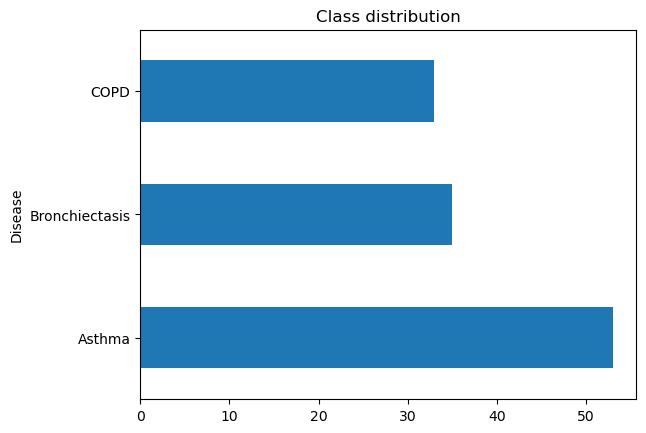

In [410]:
# class distribution
X_Y_dataset['Disease'].value_counts().plot(
    kind='barh', title='Class distribution')

there are more asthma patients than COPD and Bronchiectasis.

Text(0.5, 1.0, 'Age distribution by disease')

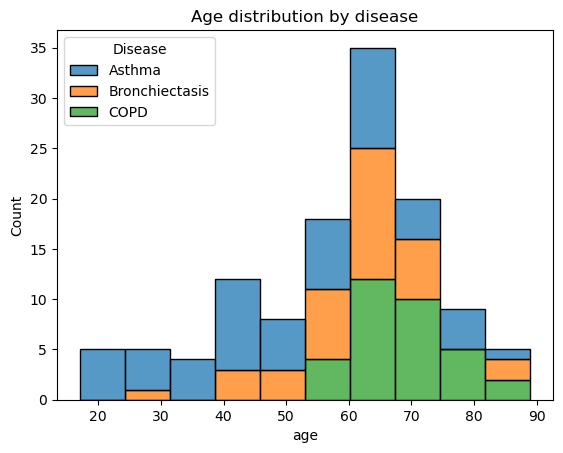

In [411]:
sns.histplot(data=X_Y_dataset, x="age", hue="Disease", multiple="stack")
plt.title('Age distribution by disease')

Asthma has the widest age distribution,

COPD has the smallest age distribution and is in older people only,

Bromchondriasis appears to be spread across randomly.

The most frequent age range is between 60 and 70.

Text(0.5, 1.0, 'BH (cm) distribution by disease')

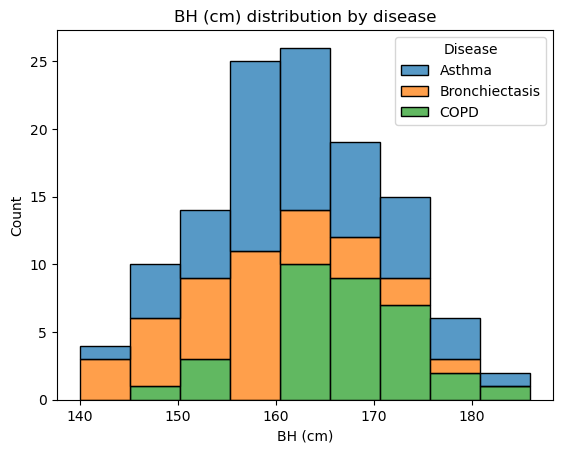

In [412]:
sns.histplot(data=X_Y_dataset, x="BH (cm)", hue="Disease", multiple="stack")
plt.title('BH (cm) distribution by disease')

BH (cm) appears to be normally distributed, with most people being around 160 cm.

Text(0.5, 1.0, 'BMI distribution by disease')

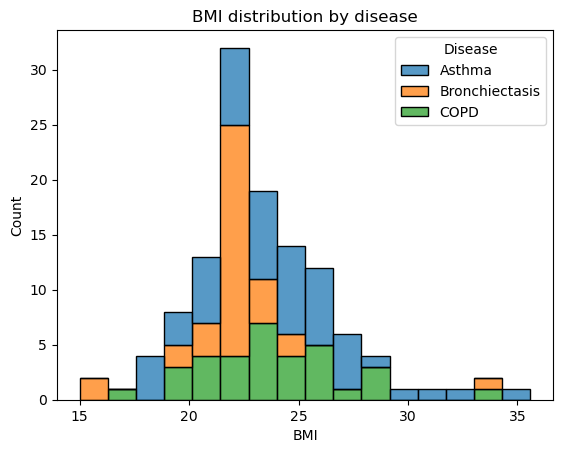

In [413]:
sns.histplot(data=X_Y_dataset, x="BMI", hue="Disease", multiple="stack")
plt.title('BMI distribution by disease')


BMI of asthmatics has the widest distribution.

BMI of Bronchiectasis is predominantly in the 22-23 range, with outliers at both ends.

BMI of COPD has a smaller distribution range. 

Text(0.5, 1.0, 'BW (kg) distribution by disease')

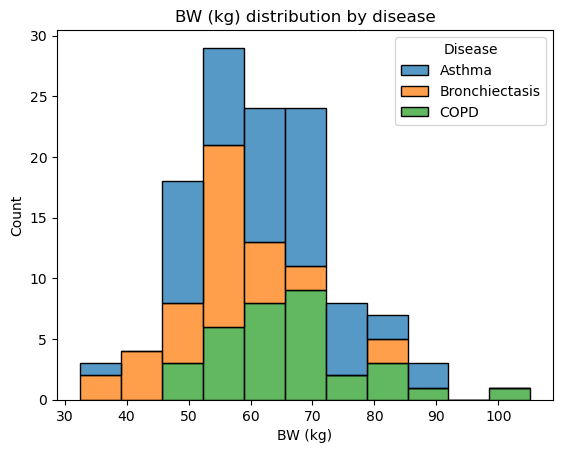

In [414]:
sns.histplot(data=X_Y_dataset, x="BW (kg)", hue="Disease", multiple="stack")
plt.title('BW (kg) distribution by disease')


BW of asthmatics has the widest distribution.

BW of Bronchiectasis is predominantly in the 55-60 range, and overall in the lower-end of the spectrum.

BW of COPD is in the higher end of the distribution.

Text(0.5, 1.0, 'FEV10 PP distribution by disease')

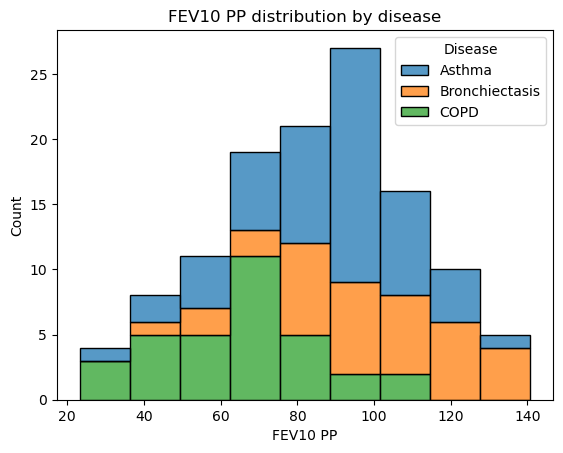

In [415]:
sns.histplot(data=X_Y_dataset, x="FEV10 PP", hue="Disease", multiple="stack")
plt.title('FEV10 PP distribution by disease')

COPD occupies a lower end of the FEV10PP, with most near 70.

Asthma has the widest range, with the most frequent value near 90.

Bronchiectasis is on the higher end of FEV10PP, with more frequent values over 90.

Text(0.5, 1.0, 'FVC PP distribution by disease')

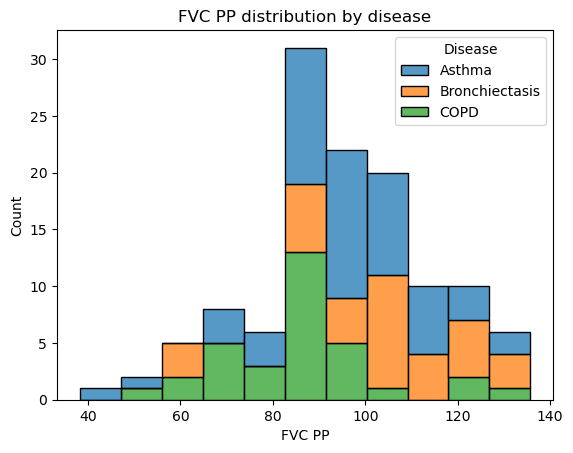

In [416]:
sns.histplot(data=X_Y_dataset, x="FVC PP", hue="Disease", multiple="stack")
plt.title('FVC PP distribution by disease')

COPD occupies a lower end of the FVC PP, with most frequent value is near 110.

Asthma has the widest range, with the most frequent value near 90.

Bronchiectasis is on the higher end of FFVC PP, with more frequent values over 100.

Text(0.5, 1.0, 'sex count by disease')

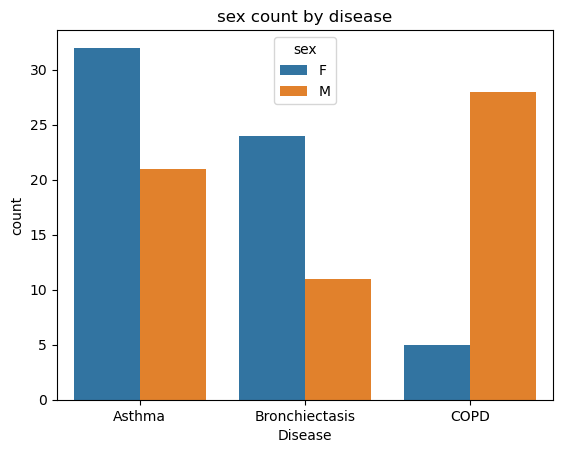

In [417]:
sex_sf = X_Y_dataset['sex'].groupby(
    X_Y_dataset['Disease']).value_counts().reset_index()
sns.barplot(data=sex_sf, x="Disease", y="count", hue="sex")
plt.title('sex count by disease')

Gender wise asthma and Bronchiectasis have a higher female %, whereas COPD has a significantly higher male %.

### Machine Learning Classification

#### Prepare data and models

In [418]:
X_Y_dataset = X_Y_dataset.drop('IUPAC Name', axis=1)  # drop IUPAC Name
X_Y_dataset['sex'] = X_Y_dataset['sex'].map(
    {'M': 0, 'F': 1})  # map sex to numbers

le = LabelEncoder()
X_Y_dataset['Disease'] = le.fit_transform(X_Y_dataset['Disease'])

# Create X and y dataframes
X = X_Y_dataset.loc[:, X_Y_dataset.columns != "Disease"]
y = X_Y_dataset.loc[:, X_Y_dataset.columns == "Disease"]

# Normalise features
standard_scaler = StandardScaler()
X_stand_scaled = standard_scaler.fit_transform(X)
variables = X.columns
X = pd.DataFrame(X_stand_scaled, columns=variables)

# models that will be trained on the data
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "K-Nearest Neighbours": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC()
}

# create holders
model_df = []
accuracy = []
f1 = []

# create kfold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

#### Train and test models

In [419]:
for train, test in kf.split(X_Y_dataset):

    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

    # upsample due to class imbalance
    ros = RandomOverSampler(sampling_strategy='not majority', random_state=0)

    for model, model_launch in models.items():

        # Loop through listed models
        model_initiated = model_launch
        model_initiated.fit(X_train, y_train.values.ravel())
        predictions = model_initiated.predict(X_test)

        # Model Names
        model_df.append(model)

        # Model Scores
        accuracy.append(accuracy_score(y_test, predictions))

scores_df_stand = pd.DataFrame({'Model': model_df,
                                'Accuracy': accuracy
                                })

#### Get Scores

In [420]:
scores_df_stand_g = scores_df_stand.groupby(by='Model').mean().sort_values(
    by='Accuracy', ascending=False).reset_index(drop=False)

scores_df_stand_g

(scores_df_stand_g.style
 .background_gradient(subset=['Accuracy'])
 .highlight_max(subset=['Accuracy'], color='gold')
 .set_caption('Model Performance 5 k-fold cross validation')
 .format({'Accuracy': "{:.2%}"
          }))

,Model,Accuracy
0,Random Forest,95.83%
1,Decision Tree,93.40%
2,Gradient Boosting,91.73%
3,SVM,82.60%
4,K-Nearest Neighbours,71.00%


#### Best Model Results

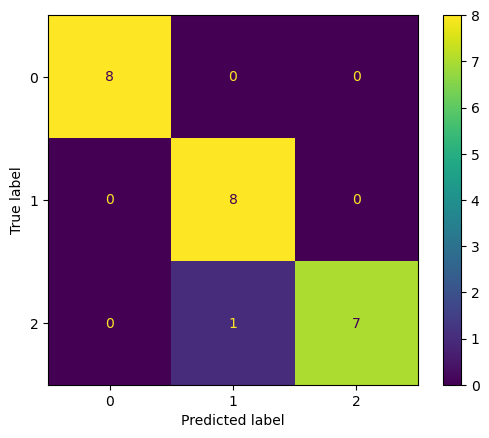

In [421]:
clf3 = models['Random Forest']
clf3.fit(X_train, y_train.values.ravel())
predictions = clf3.predict(X_test)
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm)  # , display_labels=['Malignant', 'benign')
cmd.plot()

### Feature Importance with SHAP

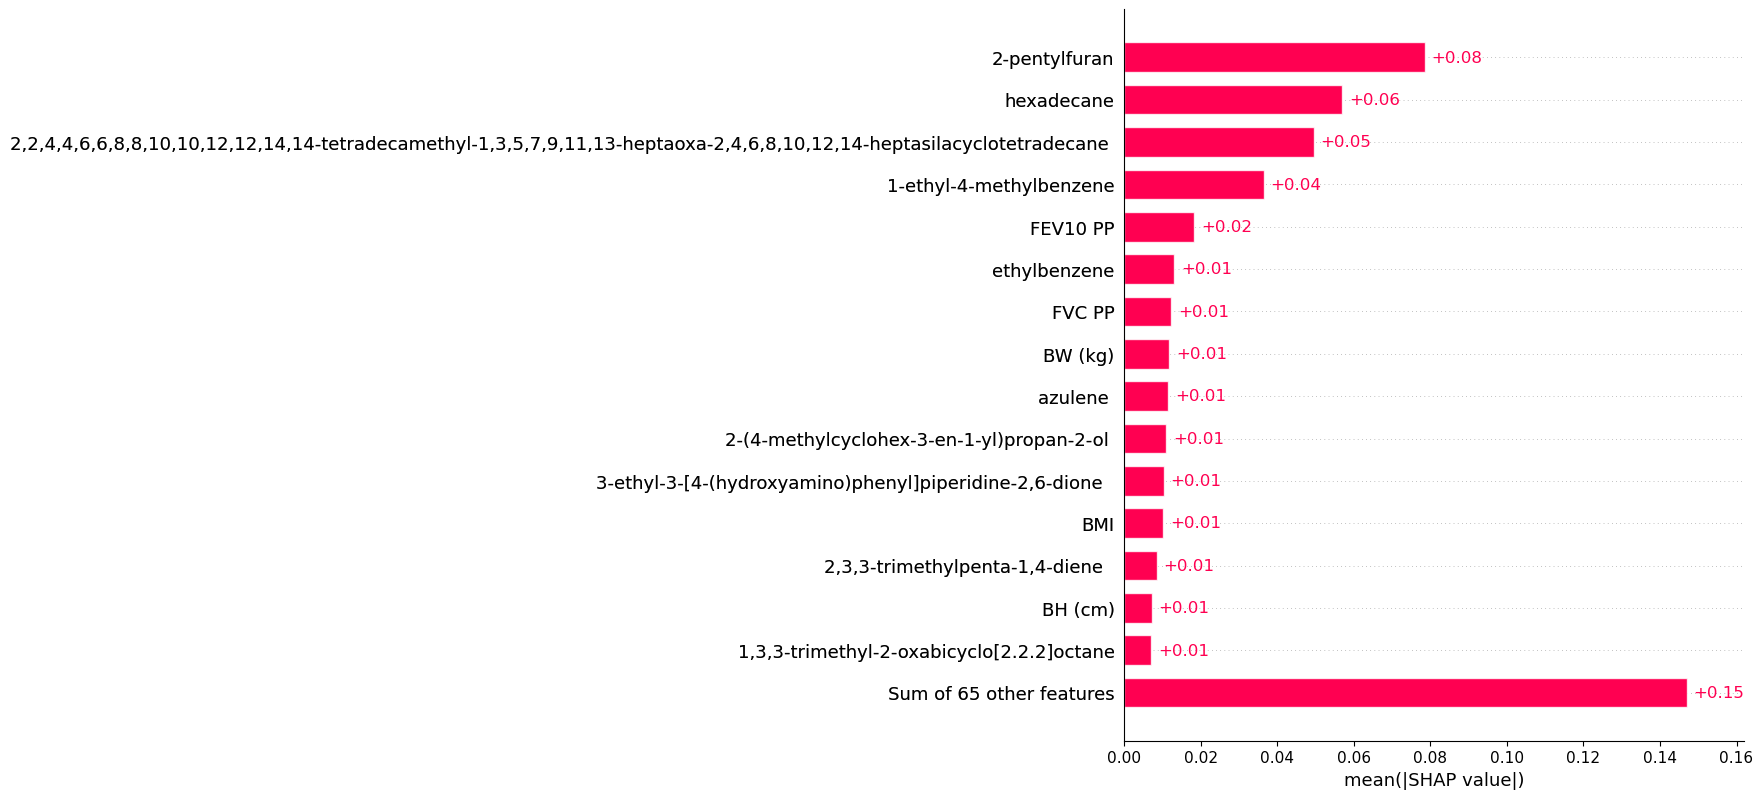

In [422]:
explainer = shap.TreeExplainer(clf3, X_train)
shap_values = explainer(X_train)
# plot 20% of the most important features
shap.plots.bar(shap_values[:, :, 1], max_display=16)

In [423]:
vals = shap_values.values
vals_abs = np.abs(vals)
vals_mean = np.mean(vals_abs, axis=0)
val_final = np.mean(vals_mean, axis=1)
feature_importance = pd.DataFrame(list(zip(shap_values.feature_names, val_final)), columns=[
                                  'col_name', 'feature_importance_val']).sort_values(
    by=['feature_importance_val'], ascending=False).reset_index(drop=True)

print("the top 10 relevant features are: \n", feature_importance.head(10))

the top 10 relevant features are: 
                                             col_name  feature_importance_val
0                                      2-pentylfuran                0.098637
1  2,2,4,4,6,6,8,8,10,10,12,12,14,14-tetradecamet...                0.064379
2                                         hexadecane                0.038067
3                            1-ethyl-4-methylbenzene                0.033673
4                                           azulene                 0.021945
5         2-(4-methylcyclohex-3-en-1-yl)propan-2-ol                 0.015375
6                                           FEV10 PP                0.014176
7                                       ethylbenzene                0.013624
8                   2,3,3-trimethylpenta-1,4-diene                  0.011096
9                                             FVC PP                0.010381


We have identified the main VOCs from individuals with asthma, bronchiectasis, and chronic obstructive pulmonary disease.

They proved to be better biomarkers than physical descriptors.

## Breast Cancer Dataset

Data extracted from https://data.mendeley.com/datasets/h7fvhycmmn/1 of the article with DOI: 10.1016/j.heliyon.2024.e32115

### read and process excel

In [424]:
breast_cancer_df_raw = pd.read_excel(
    'Data/Breast cancer-related VOCs/BC_multiomics/Basic_clinic_info.xlsx', header=None)
breast_cancer_df_raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,NaN,检测日期,住院号,性别,年龄,身高,体重,BMI,饮酒史(现在/以前/从不),吸烟史(现在/以前/从不),肿瘤家族史,肿瘤史,Drug_use,Comorbidity,Label
1,0.0,20220314,786422,0,35,158,55,22.031726,0,0,0,0,0,0,良性
2,1.0,20220314,796530,0,51,163,55,20.700817,0,0,0,0,0,0,恶性
3,2.0,20220314,792794,0,27,160,52,20.3125,0,0,0,0,0,0,良性
4,3.0,20220315,786430,0,54,162,57,21.71925,0,0,0,0,0,0,良性


In [425]:
print(breast_cancer_df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       238 non-null    float64
 1   1       239 non-null    object 
 2   2       239 non-null    object 
 3   3       239 non-null    object 
 4   4       239 non-null    object 
 5   5       239 non-null    object 
 6   6       239 non-null    object 
 7   7       239 non-null    object 
 8   8       239 non-null    object 
 9   9       239 non-null    object 
 10  10      239 non-null    object 
 11  11      239 non-null    object 
 12  12      239 non-null    object 
 13  13      239 non-null    object 
 14  14      239 non-null    object 
dtypes: float64(1), object(14)
memory usage: 28.1+ KB
None


In [426]:
# fill NA
breast_cancer_df_raw = breast_cancer_df_raw.fillna('ID')
# translate
translator = GoogleTranslator(source='auto', target='en')
for col, value in breast_cancer_df_raw.iloc[0].items():
    if isinstance(value, str):  # only translate strings
        translated_value = translator.translate(value)
        breast_cancer_df_raw.iloc[0, col] = translated_value
    else:
        breast_cancer_df_raw.iloc[0, col] = value

# make the first row headers
breast_cancer_df_raw
breast_cancer_df_raw.columns = breast_cancer_df_raw.iloc[0].values
breast_cancer_df_raw.drop(index=0, axis=0, inplace=True)

# replace label to english
breast_cancer_df_raw['Label'] = breast_cancer_df_raw['Label'].apply(
    lambda x: translator.translate(x))

breast_cancer_df_raw.head()

,ID,Test date,Hospital number,gender,age,height,body weight,BMI,Drinking history (current/former/never),Smoking history (current/former/never),Family history of cancer,History of cancer,Drug_use,Comorbidity,Label
1,0.0,20220314,786422,0,35,158,55,22.031726,0,0,0,0,0,0,benign
2,1.0,20220314,796530,0,51,163,55,20.700817,0,0,0,0,0,0,Malignant
3,2.0,20220314,792794,0,27,160,52,20.3125,0,0,0,0,0,0,benign
4,3.0,20220315,786430,0,54,162,57,21.71925,0,0,0,0,0,0,benign
5,4.0,20220315,792797,0,59,150,49,21.777778,0,0,0,0,0,0,benign


### read and process the multiple .csv

In [427]:
# specify the folder path
folder_path = 'Data/Breast cancer-related VOCs/BC_multiomics/breath-omics/'

# get a list of all .txt files in the folder
txt_files = glob.glob(folder_path + '/*.txt')

# create an empty list to store the data
name = []
data = []

# iterate over the files and read each one into a DataFrame
for file in txt_files:
    # read the file
    file_df = pd.read_csv(file, header=None, sep='\t')[1]
    name.append(file.split('/')[-1])
    data.append(file_df)

In [428]:
# create name df
cancer_name_df = pd.DataFrame(name)
# add column name
cancer_name_df.columns = ['Hospital number']
# create data df
cancer_data_df = pd.DataFrame(data).reset_index(drop=True)
# concat
cancer_voc_df = pd.concat([cancer_name_df, cancer_data_df], axis=1)
# get only patient Hospital number
cancer_voc_df['Hospital number'] = cancer_voc_df['Hospital number'].astype(
    str).str[-12:]
# sort and keep only first value
cancer_voc_df = cancer_voc_df.sort_values(
    by='Hospital number').drop_duplicates(subset='Hospital number', keep="first")
# remove end of str
cancer_voc_df['Hospital number'] = cancer_voc_df['Hospital number'].str[:6]
cancer_voc_df.head()

,Hospital number,0,1,2,3,4,5,6,7,8,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,112050,0.097884,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,112050,0.006324,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,117108,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.269746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,117108,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.269147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,133374,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.02073,0.0,...,1.044087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222357


### merge dataset and exploratory data analysis

In [429]:
breast_cancer_df_raw['Hospital number'] = breast_cancer_df_raw['Hospital number'].astype(
    str)
cancer_voc_complete_df = pd.merge(
    breast_cancer_df_raw, cancer_voc_df, on="Hospital number", how='left')
cancer_voc_complete_df.head()

,ID,Test date,Hospital number,gender,age,height,body weight,BMI,Drinking history (current/former/never),Smoking history (current/former/never),...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.0,20220314,786422,0,35,158,55,22.031726,0,0,...,0.496822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,20220314,786422,0,35,158,55,22.031726,0,0,...,0.467861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,20220314,796530,0,51,163,55,20.700817,0,0,...,0.715224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,20220314,796530,0,51,163,55,20.700817,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,20220314,792794,0,27,160,52,20.3125,0,0,...,0.626324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [430]:
print("The dataset is now constructed with {} samples and {} features".format(
    cancer_voc_complete_df.shape[0], cancer_voc_complete_df.shape[1]))

The dataset is now constructed with 476 samples and 1515 features


<Axes: title={'center': 'Class distribution'}, ylabel='Label'>

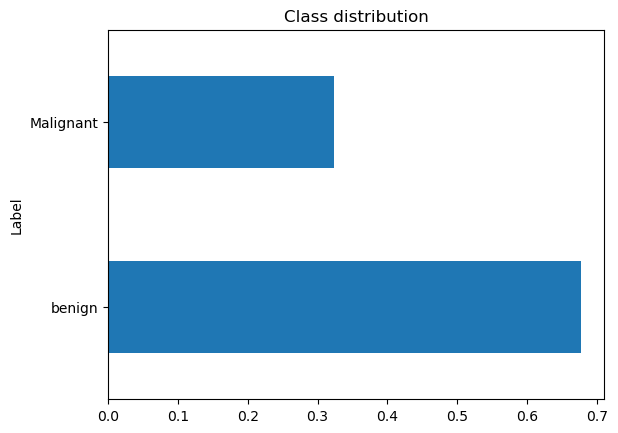

In [431]:
cancer_voc_complete_df['Label'].value_counts(normalize=True).plot(
    kind='barh', title='Class distribution')

classes are unbalanced, with nearly 70% being benign.

Text(0.5, 1.0, 'gender distribution by label')

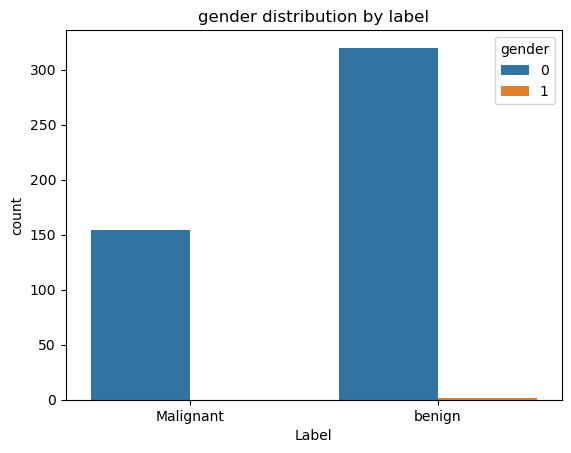

In [432]:
c_gender_sf = cancer_voc_complete_df['gender'].groupby(
    cancer_voc_complete_df['Label']).value_counts().reset_index()
sns.barplot(data=c_gender_sf, x="Label", y="count", hue="gender")
plt.title('gender distribution by label')

There are very few male patients, they are mostly female.

Text(0.5, 1.0, 'age distribution by label')

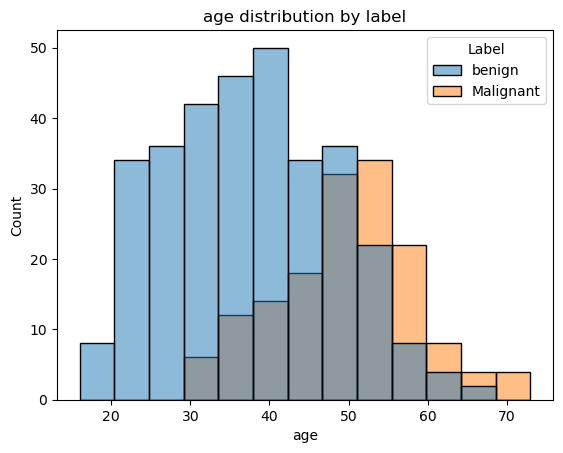

In [433]:
cancer_voc_complete_df['age'] = cancer_voc_complete_df['age'].astype(int)
sns.histplot(data=cancer_voc_complete_df, x="age", hue="Label", alpha=0.5)
plt.title('age distribution by label')

patients with malignant cancer are on average older than benign, with the modes being 40 and 55 respectively.

Text(0.5, 1.0, 'height distribution by label')

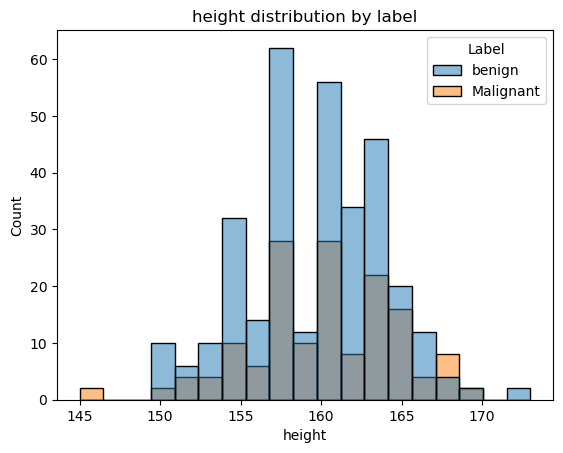

In [434]:
sns.histplot(data=cancer_voc_complete_df, x="height", hue="Label", alpha=0.5)
plt.title('height distribution by label')

height distribution among both classes is similar.

Text(0.5, 1.0, 'body weight distribution by label')

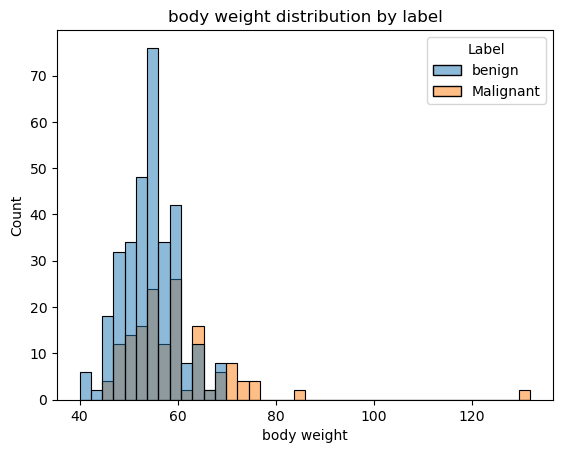

In [435]:
sns.histplot(data=cancer_voc_complete_df,
             x="body weight", hue="Label", alpha=0.5)
plt.title('body weight distribution by label')

benign patients have lower body weight than malignant patients.

Text(0.5, 1.0, 'BMI distribution by label')

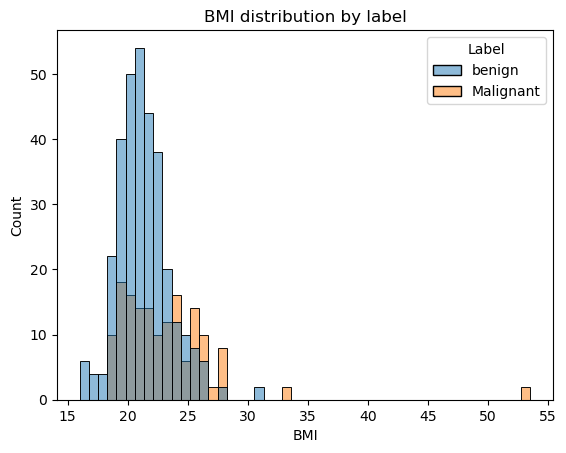

In [436]:
sns.histplot(data=cancer_voc_complete_df,
             x="BMI", hue="Label", alpha=0.5)
plt.title('BMI distribution by label')

benign patients have lower BMI than malignant patients.

Text(0.5, 1.0, 'Drinking history (current/former/never) proportion by label')

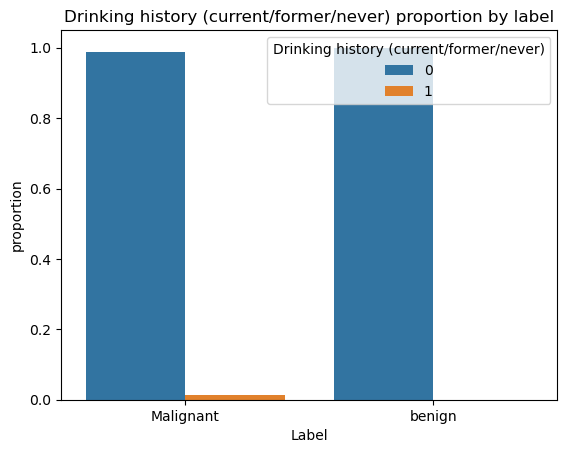

In [437]:
c_drink_sf = cancer_voc_complete_df['Drinking history (current/former/never)'].groupby(
    cancer_voc_complete_df['Label']).value_counts(normalize=True).reset_index()
sns.barplot(data=c_drink_sf, x="Label", y="proportion",
            hue="Drinking history (current/former/never)")
plt.title('Drinking history (current/former/never) proportion by label')

very few patients have a drinking history regardless of label.

Text(0.5, 1.0, 'Smoking history (current/former/never) proportion by label')

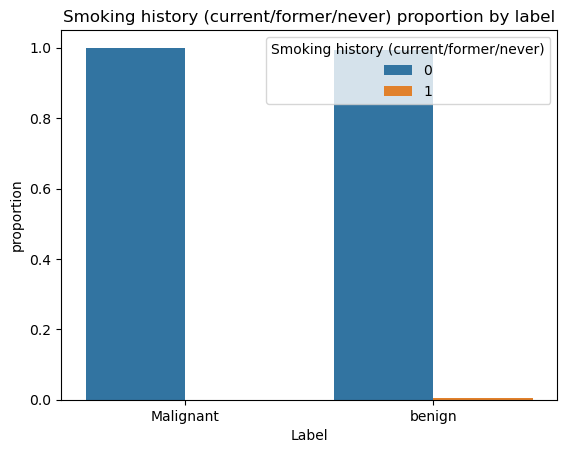

In [438]:
c_smoke_sf = cancer_voc_complete_df['Smoking history (current/former/never)'].groupby(
    cancer_voc_complete_df['Label']).value_counts(normalize=True).reset_index()
sns.barplot(data=c_smoke_sf, x="Label", y="proportion",
            hue="Smoking history (current/former/never)")
plt.title('Smoking history (current/former/never) proportion by label')

very few patients have a smoking history regardless of label.

Text(0.5, 1.0, 'Family history of cancer porportion by label')

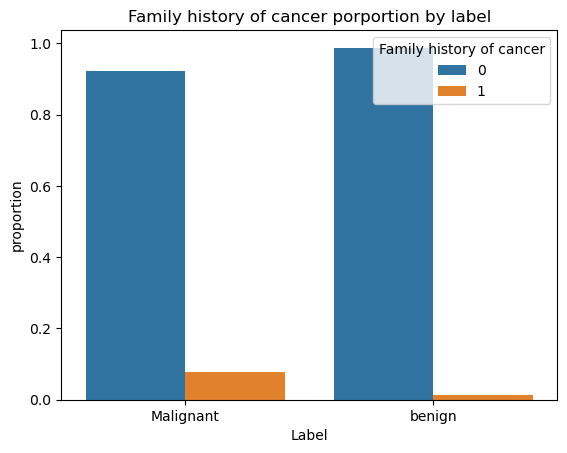

In [439]:
c_family_c_sf = cancer_voc_complete_df['Family history of cancer'].groupby(
    cancer_voc_complete_df['Label']).value_counts(normalize=True).reset_index()
sns.barplot(data=c_family_c_sf, x="Label", y="proportion",
            hue="Family history of cancer")
plt.title('Family history of cancer porportion by label')

There is a higher proportion of malignant patients with a family history of cancer.

Text(0.5, 1.0, 'History of cancer proportion by label')

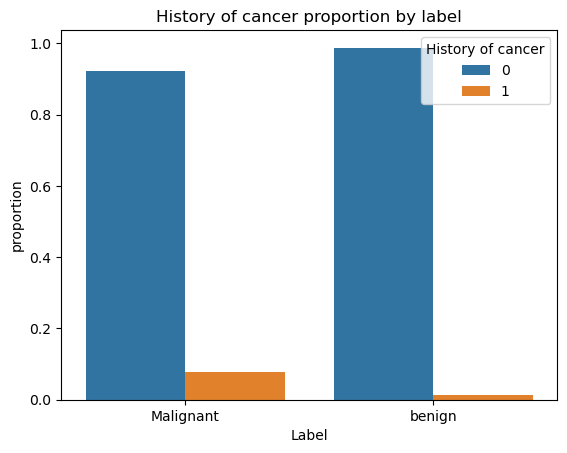

In [440]:
c_history_c_sf = cancer_voc_complete_df['History of cancer'].groupby(
    cancer_voc_complete_df['Label']).value_counts(normalize=True).reset_index()
sns.barplot(data=c_history_c_sf, x="Label", y="proportion",
            hue="History of cancer")
plt.title('History of cancer proportion by label')

There is a higher proportion of malignant patients with a history of cancer.

Text(0.5, 1.0, 'Drug use proportion by label')

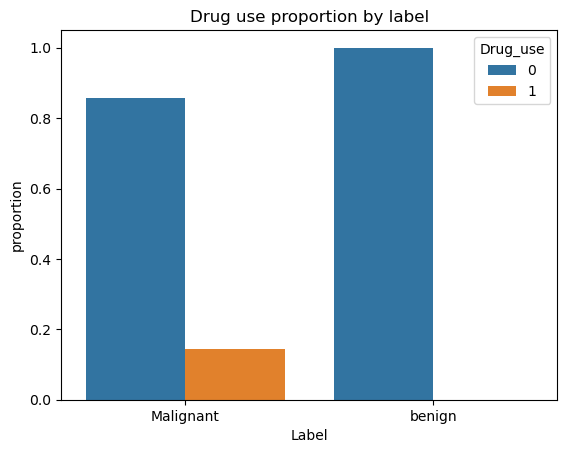

In [441]:
c_drug_use_sf = cancer_voc_complete_df['Drug_use'].groupby(
    cancer_voc_complete_df['Label']).value_counts(normalize=True).reset_index()
sns.barplot(data=c_drug_use_sf, x="Label", y="proportion",
            hue="Drug_use")
plt.title('Drug use proportion by label')

There is a higher proportion of malignant patients with drug use.

Text(0.5, 1.0, 'Comorbidity proportion by label')

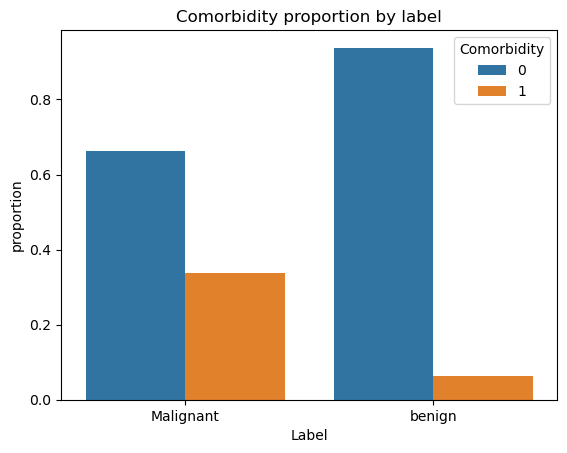

In [442]:
c_cormobidities_sf = cancer_voc_complete_df['Comorbidity'].groupby(
    cancer_voc_complete_df['Label']).value_counts(normalize=True).reset_index()
sns.barplot(data=c_cormobidities_sf, x="Label", y="proportion",
            hue="Comorbidity")
plt.title('Comorbidity proportion by label')

There is a higher proportion of malignant patients with Cormobidity.

Text(0.5, 1.0, 'average malignant m/z')

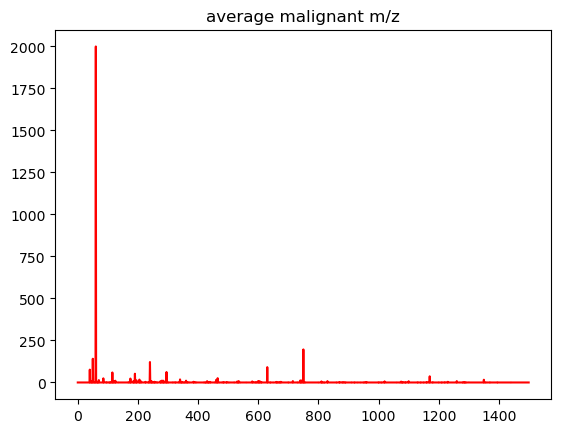

In [443]:
malignant_df = cancer_voc_complete_df[cancer_voc_complete_df['Label'] == 'Malignant']
malignant_df = malignant_df.iloc[:, 15:].mean(axis=0)
sns.lineplot(data=malignant_df, c='r')
plt.title("average malignant m/z")

Text(0.5, 1.0, 'average benign m/z')

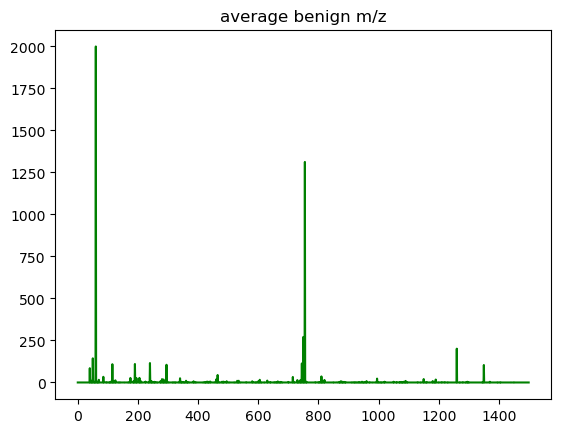

In [444]:
benign_df = cancer_voc_complete_df[cancer_voc_complete_df['Label'] == 'benign']
benign_df = benign_df.iloc[:, 15:].mean(axis=0)
sns.lineplot(data=benign_df, c='g')
plt.title("average benign m/z")

In [445]:
cancer_voc_complete_df

,ID,Test date,Hospital number,gender,age,height,body weight,BMI,Drinking history (current/former/never),Smoking history (current/former/never),...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.0,20220314,786422,0,35,158,55,22.031726,0,0,...,0.496822,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.0,20220314,786422,0,35,158,55,22.031726,0,0,...,0.467861,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,1.0,20220314,796530,0,51,163,55,20.700817,0,0,...,0.715224,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,1.0,20220314,796530,0,51,163,55,20.700817,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,2.0,20220314,792794,0,27,160,52,20.3125,0,0,...,0.626324,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,235.0,20221121,646428,0,27,153,47,20.077748,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
472,236.0,20221121,831160,0,24,160,49,19.140625,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
473,236.0,20221121,831160,0,24,160,49,19.140625,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
474,237.0,20221121,763028,0,46,160,85,33.203125,0,0,...,0.528105,0.0,0.0,0.0,0.0,0.477345,0.0,0.0,0.0,0.000000


### Machine Learning Classification

#### Prepare data and models

In [446]:
X_Y_dataset = cancer_voc_complete_df.drop(
    ['ID', 'Test date', 'Hospital number'], axis=1)  # drop IUPAC Name

X_Y_dataset.columns = X_Y_dataset.columns.astype(str)

le = LabelEncoder()
X_Y_dataset['Label'] = le.fit_transform(X_Y_dataset['Label'])

# Create X and y dataframes
X = X_Y_dataset.loc[:, X_Y_dataset.columns != "Label"]
y = X_Y_dataset.loc[:, X_Y_dataset.columns == "Label"]

# Normalise features
standard_scaler = StandardScaler()
X_stand_scaled = standard_scaler.fit_transform(X)
variables = X.columns
X = pd.DataFrame(X_stand_scaled, columns=variables)

# models that will be trained on the data
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "K-Nearest Neighbours": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC()
}

# create holders
model_df = []
accuracy = []
precision = []
recall = []
f1 = []

# create kfold
kf = KFold(n_splits=5, shuffle=True, random_state=0)

#### Train and test models

In [447]:
for train, test in kf.split(X_Y_dataset):

    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

    # upsample due to class imbalance
    ros = RandomOverSampler(sampling_strategy='not majority', random_state=0)

    X_train, y_train = ros.fit_resample(X_train, y_train)

    for model, model_launch in models.items():

        # Loop through listed models
        model_initiated = model_launch
        model_initiated.fit(X_train, y_train.values.ravel())
        predictions = model_initiated.predict(X_test)

        # Model Names
        model_df.append(model)

        # Model Scores
        accuracy.append(accuracy_score(y_test, predictions))
        precision.append(precision_score(y_test, predictions))
        recall.append(recall_score(y_test, predictions))
        f1.append(f1_score(y_test, predictions))


scores_df_stand = pd.DataFrame({'Model': model_df,
                                'Accuracy': accuracy,
                                'Precision': precision,
                                'Recall': recall,
                                'F1': f1}).sort_values(by='Accuracy', ascending=False)

### Get Scores

In [448]:
scores_df_stand_g = scores_df_stand.groupby(by='Model').mean().sort_values(
    by='Accuracy', ascending=False).reset_index(drop=False)

scores_df_stand_g

(scores_df_stand_g.style
 .background_gradient(subset=['Accuracy', 'Precision', 'Recall', 'F1'])
 .highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F1'], color='gold')
 .set_caption('Model Performance 5 k-fold cross validation')
 .format({'Accuracy': "{:.2%}",
          'Precision': "{:.2%}",
          'Recall': "{:.2%}",
          'F1': "{:.2%}"
          }))

,Model,Accuracy,Precision,Recall,F1
0,Gradient Boosting,94.54%,94.40%,97.85%,96.02%
1,Random Forest,93.48%,93.72%,96.86%,95.24%
2,SVM,88.44%,90.60%,92.48%,91.49%
3,Decision Tree,85.71%,89.86%,89.24%,89.38%
4,K-Nearest Neighbours,78.58%,94.07%,73.12%,82.15%


#### Best Model Results

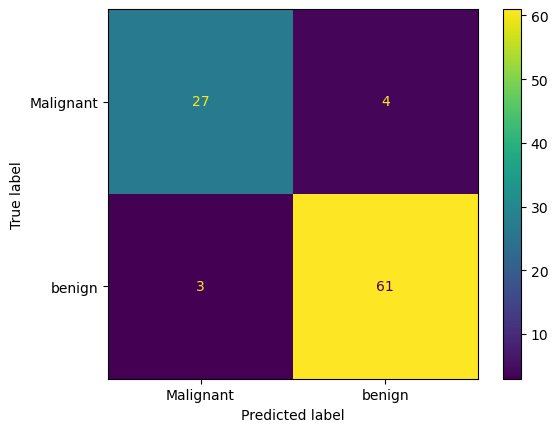

In [449]:
clf3 = models['Random Forest']
clf3.fit(X_train, y_train.values.ravel())
predictions = clf3.predict(X_test)
cm = confusion_matrix(y_test, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Malignant', 'benign'
                                                 ])
cmd.plot()

### Feature Importance with SHAP

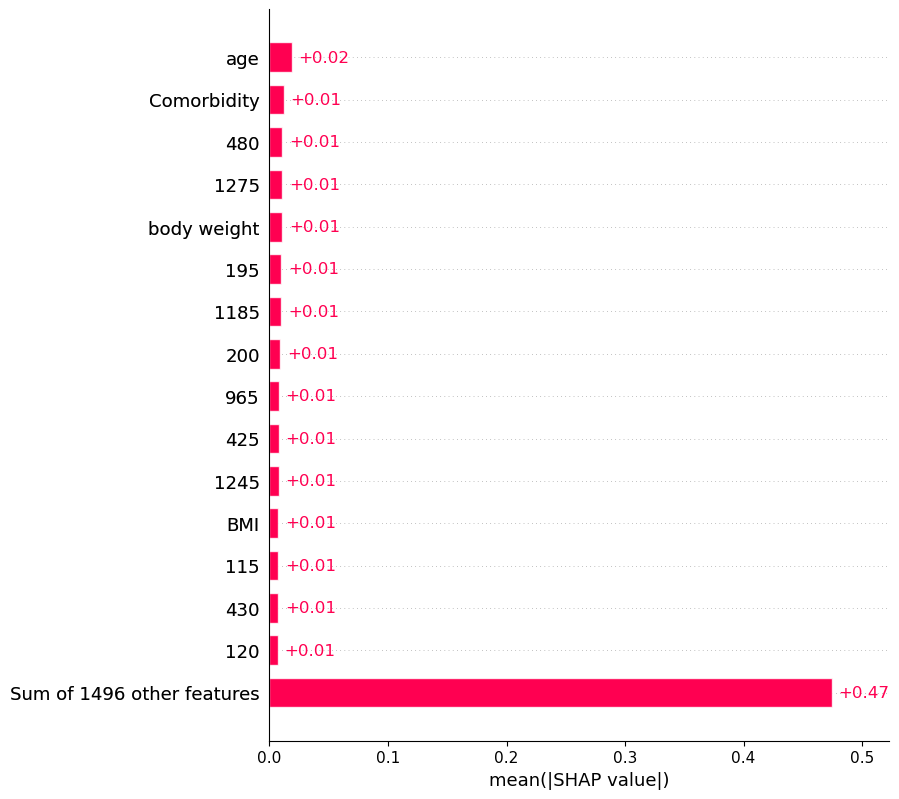

In [450]:
explainer = shap.TreeExplainer(clf3, X_train)
shap_values = explainer(X_train, check_additivity=False)
# plot 20% of the most important features
shap.plots.bar(shap_values[:, :, 1], max_display=16)

In [451]:
vals = shap_values.values
vals_abs = np.abs(vals)
vals_mean = np.mean(vals_abs, axis=0)
val_final = np.mean(vals_mean, axis=1)
feature_importance = pd.DataFrame(list(zip(shap_values.feature_names, val_final)), columns=[
                                  'col_name', 'feature_importance_val']).sort_values(
    by=['feature_importance_val'], ascending=False).reset_index(drop=True)

print("the top 10 relevant features are: \n", feature_importance.head(10))

the top 10 relevant features are: 
       col_name  feature_importance_val
0          age                0.018927
1  Comorbidity                0.012018
2          480                0.011041
3         1275                0.011014
4  body weight                0.010820
5          195                0.010074
6         1185                0.010069
7          200                0.009146
8          965                0.008108
9          425                0.008040
